<a href="https://colab.research.google.com/github/sunohk/dataon_pj/blob/main/%ED%95%99%EC%8A%B5_%EC%BD%94%EB%93%9C/3_kobert_gelu_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-5dy371jk/kobert-tokenizer_f18e3a7f66924e5ebab779a6acb5fd58
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-5dy371jk/kobert-tokenizer_f18e3a7f66924e5ebab779a6acb5fd58
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


# 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [ ]:
raw_data = pd.read_excel('gdrive/MyDrive/공모전/2023_News/Datasets/Train_data/Train_updated.xlsx', index_col = 0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4864 entries, 0 to 4863
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        4864 non-null   object
 1   User        4864 non-null   object
 2   Summary     4864 non-null   object
 3   Label       4864 non-null   int64 
 4   Type        4864 non-null   object
 5   Topic       4864 non-null   object
 6   clean_text  4864 non-null   object
dtypes: int64(1), object(6)
memory usage: 304.0+ KB


In [ ]:
raw_data.head()

,Date,User,Summary,Label,Type,Topic,clean_text
0,2020-03-24 00:00:00,tkadnjs4770,"#장병완 의원, ‘#청년에게_용기를’ #청년정책 공약 발표\n\n“주거와 취업은 청...",1,트위터,청년정책,장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 ...
1,2019-09-15 00:00:00,FairSociety88,"이재명이 있잖아! \n\n최초의 청년배당 청년정책들, 이 모든 정책을 봐! \n\...",0,트위터,청년정책,이재명 최초 청년 배당 청년 정책 정책 이 재명 청년 지원 정치 인 재명 포함 청년...
2,2019-12-19 00:00:00,TheKoreanOfWill,* #2019년12월19일 의 #오늘의이야기1\n\n: #국무조정실 #청년정책추진단...,1,트위터,청년정책,오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기...
3,2021-05-08 00:00:00,OhmyNews_Korea,'청년'으로 도마 위 오른 이재명과 오세훈 #이재명 #청년정책 #서울시 #오세훈 #...,1,트위터,청년정책,청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자
4,2019-05-02 00:00:00,DikesEye,국무총리실을 청년정책 콘트롤타워로…청년정책조정위 설치 http://yna.kr/AK...,1,트위터,청년정책,국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치


In [ ]:
#스팸열 제거
spam_str = ['자동트윗','특강','캣맘','애견','하반기 뉴스','간추린뉴스','특수형광물질','호수마을 아파트','미사일','헤드라인','힙합엘이','조성진','김석진','마인드컨트롤전파무기','파리','그린가드','흥신소',
           '초음파검사','돌고래','부린이','오픈채팅방','문의전화','주식', '돈쭐','상담문의','광고문의','속도위반','역사교과서','일러스트레이터','데이트미팅','노사갈등',
            '동성결혼','마인드컨트롤','고속도로','음주운전'"차용증","아이유","일본어라 논의해야함","선지국","미국증시","하데스","인싸","오버워치","젠몬","오마이걸","파이어족","먹부림","서울지갑","안전운임제","샹젤리제",
# "대한변협","안성시성폭력변호사상담","원씽","상하이컨테이너운","뇌전증","트레저아일랜드","외국인반응","슬의","비욘드조닝","공정가액비율",
# "실전부동산스터디","청라언덕","탄소국경세","샤오펑","계약갱신권","노무라","우왕좌왕","코리빙업체","자유롭게","부동산 주요뉴스","딥테크","할리스커피","주요뉴스","아침뉴스","주간일기",
# "인천사기변호사","황투바오","출석요구","간추린","뜨리공주","전농우성","미세먼지","리페어","신학기","기초생활수급자","Beginagain",
# "김밥전","테헤란","파트너스","슬러시","청학풀장","물적분할","배액관","오픽","강동원","블랙스톤","일반상식","생소한","대쉬","울림더하기",
# "레미콘","생타계","하르툼","음란마귀","김포골드라인","현대로템","평산책방","남양주맛집","대학가","넷플릭스","어머니","레드카드","롤리팝","음란마귀",
# "핵위협","함평나비축제","전화조사원","포드사","브람스","나침반","골드라인","씨티탐정","자동차그룹","옥탑방","의왕고천","Equity",
# "어버이날","유니클로","촉법소년","순환철도망","싸이코패스","민방위","명품족","김포법률상담변호사","알프스","에드워드","서학개미","디벨로퍼",
# "센트럴파크","국가보훈부","마이크론","해저터널","토왜막부","안산개인회생법무사","구미호뎐","엔비디아","어묵","글 이상","옥석가리기","맛집",
# "데드캣","옥석가리기","입영열차","툽깅","사내뷰공업","인구쇼크","특수상해","다이어트약","타이타닉","학교폭력전문변호사","경찰총경"
]
# Filter the DataFrame to remove rows containing the specified string
spam_condition = raw_data['Summary'].apply(lambda x: not any(spam in x for spam in spam_str))
print(spam_condition)
data = raw_data[spam_condition]
data.head()

0        True
1       False
2        True
3        True
4        True
        ...  
4859     True
4860     True
4861     True
4862     True
4863     True
Name: Summary, Length: 4864, dtype: bool


,Date,User,Summary,Label,Type,Topic,clean_text
0,2020-03-24 00:00:00,tkadnjs4770,"#장병완 의원, ‘#청년에게_용기를’ #청년정책 공약 발표\n\n“주거와 취업은 청...",1,트위터,청년정책,장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 ...
2,2019-12-19 00:00:00,TheKoreanOfWill,* #2019년12월19일 의 #오늘의이야기1\n\n: #국무조정실 #청년정책추진단...,1,트위터,청년정책,오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기...
3,2021-05-08 00:00:00,OhmyNews_Korea,'청년'으로 도마 위 오른 이재명과 오세훈 #이재명 #청년정책 #서울시 #오세훈 #...,1,트위터,청년정책,청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자
4,2019-05-02 00:00:00,DikesEye,국무총리실을 청년정책 콘트롤타워로…청년정책조정위 설치 http://yna.kr/AK...,1,트위터,청년정책,국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치
5,2021-12-01 00:00:00,yoomyongsook,"결국, 윤석열도 부자본색?? 2030세대 난리났다! 윤석열, 주 52시간 최저임금 ...",0,트위터,청년정책,윤석열 부자 본색 세대 난리 윤석열 주 최저임금 폐지 언급 재명 감동 청년 정책 강...


0    2523
1    2136
Name: Label, dtype: int64

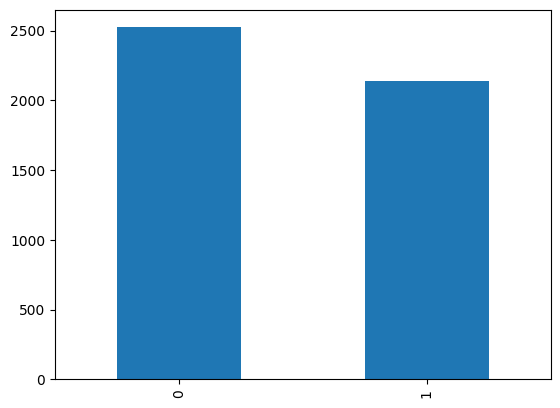

In [ ]:
data['Label'].value_counts().plot(kind='bar')
data['Label'].value_counts()

In [ ]:
data_list = []
for q, label in zip(data['clean_text'], data['Label']):
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 23)

print('훈련용 리뷰의 개수 : ', len(dataset_train))
print('테스트용 리뷰의 개수 : ', len(dataset_test))

훈련용 리뷰의 개수 :  3727
테스트용 리뷰의 개수 :  932


# 모델 불러오기

In [ ]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

In [ ]:
import gluonnlp as nlp
from transformers import BertModel
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [ ]:
# # 하이퍼 파라미터 설정
max_len = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

In [ ]:
# GELU

import torch
import torch.nn as nn
import torch.nn.functional as F  # Import for GELU

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=2,
                 dr_rate=0.5,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate                    #dropout to avoid overfitting

        self.classifier = nn.Linear(hidden_size, num_classes, 'weight_decay')
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)

        # Apply GELU activation
        out = F.gelu(out)

        return self.classifier(out)


In [ ]:
#@title koBERT original

# class BERTClassifier(nn.Module):
#     def __init__(self,
#                  bert,
#                  hidden_size = 768,
#                  num_classes = 2,   # 감정 클래스 수로 조정 긍정/부정 클래스2개
#                  dr_rate = 0.2,
#                  params = None):
#         super(BERTClassifier, self).__init__()
#         self.bert = bert
#         self.dr_rate = dr_rate

#         self.classifier = nn.Linear(hidden_size , num_classes)
#         if dr_rate:
#             self.dropout = nn.Dropout(p = dr_rate)

#     def gen_attention_mask(self, token_ids, valid_length):
#         attention_mask = torch.zeros_like(token_ids)
#         for i, v in enumerate(valid_length):
#             attention_mask[i][:v] = 1
#         return attention_mask.float()

#     def forward(self, token_ids, valid_length, segment_ids):
#         attention_mask = self.gen_attention_mask(token_ids, valid_length)

#         _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
#         if self.dr_rate:
#             out = self.dropout(pooler)
#         return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]


optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 모델 학습

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch, gc

train_history = []
test_history = []
loss_history = []
f1_history = []
precision_history = []
recall_history = []

for e in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()

    train_acc = 0.0                   #accuracy initialized
    test_acc = 0.0
    test_f1 = 0.0
    test_precision = 0.0
    test_recall = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()        #gradient zeroed
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)    #calculate loss
        loss.backward()               #backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수

    model.eval()      #evaluation mode
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        test_f1 = f1_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')
        test_precision = precision_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')
        test_recall = recall_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')

    print("epoch {} test acc {} test_F1 {} test_Precision {} test_Recall {}".format(
    e+1,test_acc / (batch_id+1), test_f1, test_precision, test_recall))
    test_history.append(test_acc / (batch_id+1))
    f1_history.append(test_f1)
    precision_history.append(test_precision)
    recall_history.append(test_recall)

  0%|          | 0/59 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6739702224731445 train acc 0.578125
epoch 1 train acc 0.5754590395480226


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 test acc 0.7724537037037037 test_F1 0.8109100445843168 test_Precision 0.8771929824561403 test_Recall 0.8055555555555556


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.5531368851661682 train acc 0.78125
epoch 2 train acc 0.7505120056497175


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2 test acc 0.762962962962963 test_F1 0.6970398970398971 test_Precision 0.8405797101449275 test_Recall 0.6944444444444444


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.4062088429927826 train acc 0.828125
epoch 3 train acc 0.8215042372881356


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3 test acc 0.7585648148148147 test_F1 0.7265221878224973 test_Precision 0.8484848484848485 test_Recall 0.7222222222222222


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.3119523525238037 train acc 0.859375
epoch 4 train acc 0.8582450564971751


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4 test acc 0.8042824074074074 test_F1 0.8595090209997042 test_Precision 0.8593939393939394 test_Recall 0.8611111111111112


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.2567894160747528 train acc 0.90625
epoch 5 train acc 0.9046610169491526


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5 test acc 0.8092592592592592 test_F1 0.890746934225195 test_Precision 0.8982683982683982 test_Recall 0.8888888888888888


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.13930466771125793 train acc 0.953125
epoch 6 train acc 0.9435911016949152


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6 test acc 0.7765046296296296 test_F1 0.7008547008547009 test_Precision 0.7968253968253968 test_Recall 0.6944444444444444


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.12317922711372375 train acc 0.96875
epoch 7 train acc 0.9674258474576272


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7 test acc 0.7958333333333333 test_F1 0.7568843430369787 test_Precision 0.8204334365325077 test_Recall 0.75


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.03109242394566536 train acc 1.0
epoch 8 train acc 0.9777542372881356


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 8 test acc 0.8141203703703703 test_F1 0.8110130981021118 test_Precision 0.847265221878225 test_Recall 0.8055555555555556


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.013489073142409325 train acc 1.0
epoch 9 train acc 0.9833156779661016


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 9 test acc 0.8236111111111111 test_F1 0.9174468085106382 test_Precision 0.919732441471572 test_Recall 0.9166666666666666


  0%|          | 0/59 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.013092068955302238 train acc 1.0
epoch 10 train acc 0.9878177966101694


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 10 test acc 0.812037037037037 test_F1 0.8110130981021118 test_Precision 0.847265221878225 test_Recall 0.8055555555555556


시각화

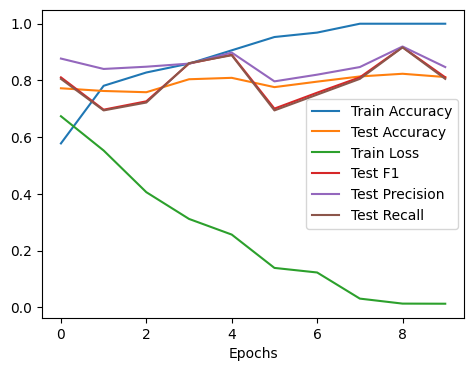

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
    # 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_history, label='Train Accuracy')
plt.plot(test_history, label='Test Accuracy')
plt.plot(loss_history, label='Train Loss')
plt.plot(f1_history, label='Test F1')
plt.plot(precision_history, label='Test Precision')
plt.plot(recall_history, label='Test Recall')

plt.xlabel('Epochs')
plt.legend()

plt.show()



In [ ]:
#Gelu & more spam

print(max(test_history))
print(max(precision_history))
print(max(recall_history))
print(max(f1_history))

0.8236111111111111
0.919732441471572
0.9166666666666666
0.9174468085106382


In [ ]:
# print(max(test_history))
# print(max(precision_history))
# print(max(recall_history))
# print(max(f1_history))

Extract mislabeled data

In [ ]:
#Create a function to evaluate the model on the test dataset and collect predictions:

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in dataloader:
            token_ids, valid_length, segment_ids, labels = batch
            token_ids = token_ids.to(device)
            segment_ids = segment_ids.to(device)
            valid_length = valid_length
            labels = labels.to(device)

            # Forward pass to get model predictions
            predictions = model(token_ids, valid_length, segment_ids)
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return all_predictions, true_labels

In [ ]:
#Use the evaluate_model function to obtain predictions and true labels:
predicted_labels, true_labels = evaluate_model(model, test_dataloader)

In [ ]:
#Compare predictions with true labels to identify mislabeled data:
mislabeled_indices = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred != true]


In [ ]:
#Extract the mislabeled data:
mislabeled_data = [dataset_test[i] for i in mislabeled_indices]
mislabeled_data

In [ ]:
PATH = 'gdrive/MyDrive/공모전/2023_News/Yen'
torch.save(model.state_dict(), 'gdrive/MyDrive/공모전/2023_News/Yen/koBERT/gelu_final_model.pt')  # 모델 객체의 state_dict 저장

Research:

https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb